Camera Calibration with OpenCV
===

In [1]:
from helper import *
print("col:", col, "row:", row)

col: 9 row: 6


In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((row*col,3), np.float32)
objp[:,:2] = np.mgrid[0:col, 0:row].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (col,row), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (col,row), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        cv2.imshow('img', img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

In [3]:
print("src")
print(src)
print("dst")
print(dst)

src
[[  712.   447.]
 [ 1305.   720.]
 [    6.   720.]
 [  570.   447.]]
dst
[[ 1280.     0.]
 [ 1280.   720.]
 [    0.   720.]
 [    0.     0.]]


* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [4]:
perspective_M, invert_perspective_M = cv2.getPerspectiveTransform(src, dst), cv2.getPerspectiveTransform(dst, src)
img_size = (1280, 720)
# Do camera calibration given object points and image points
# mtx is the calibration matrix
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    
# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["objpoints"] = objpoints
dist_pickle["imgpoints"] = imgpoints
dist_pickle["perspective_M"] = perspective_M
dist_pickle["invert_perspective_M"] = invert_perspective_M
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "wide_dist_pickle.p", "wb" ) )

In [5]:
#calibration matrix
mtx

array([[  1.15777829e+03,   0.00000000e+00,   6.67113866e+02],
       [  0.00000000e+00,   1.15282230e+03,   3.86124658e+02],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00]])

In [6]:
# distortion coefficients = (k1 k2 p1 p2 p3)
dist

array([[-0.24688572, -0.02372824, -0.00109832,  0.00035104, -0.00260433]])

In [7]:
dist_pickle = pickle.load( open( "wide_dist_pickle.p", "rb" ) )
objpoints = dist_pickle["objpoints"]
imgpoints = dist_pickle["imgpoints"]
perspective_M = dist_pickle["perspective_M"]
invert_perspective_M = dist_pickle["invert_perspective_M"]
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

In [8]:
# Edit this function to create your own pipeline.
def get_binary_img(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    color_binary = color_binary.astype(np.uint8)
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary


def fit_lane_line(img, binary_warped, invert_perspective_M):
    
    # Detect lane pixels and fit to find the lane boundary.
    
    global left_fit, right_fit
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, invert_perspective_M, (binary_warped.shape[1], binary_warped.shape[0])) 
    # Warp the detected lane boundaries back onto the original image.
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    
    return result, out_img, left_fitx, right_fitx, ploty

In [9]:
def fit_lane_line_continue(img, binary_warped, invert_perspective_M):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    
    # Detect lane pixels and fit to find the lane boundary.
    
    global left_fit, right_fit
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, invert_perspective_M, (binary_warped.shape[1], binary_warped.shape[0])) 
    # Warp the detected lane boundaries back onto the original image.
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)

    return result, out_img, left_fitx, right_fitx, ploty

In [10]:
def process_image(image):
    global left_fit, right_fit, process_count
    global mtx, dist, perspective_M, invert_perspective_M
    undist_img = cv2.undistort(image, mtx, dist, None, mtx)
    
    # Apply a perspective transform to rectify binary image ("birds-eye view").
    top_down = cv2.warpPerspective(undist_img, perspective_M, (image.shape[1], image.shape[0]))
    
    # Detect lane pixels and fit to find the lane boundary.
    binary_warped = get_binary_img(top_down)
    
    process_count = 0
    
    # find the lane boundary
    if process_count == 0:
        result, out_img, left_fitx, right_fitx, ploty = fit_lane_line(image, binary_warped, invert_perspective_M)
    else:
        result, out_img, left_fitx, right_fitx, ploty = fit_lane_line_continue(image, binary_warped, invert_perspective_M)
    
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    # Determine the curvature of the lane and vehicle position with respect to center.
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    cv2.putText(result, str(left_curverad) + ',' + str(right_curverad), (50, 80), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 2, cv2.LINE_AA)
    #print(left_curverad, right_curverad)
    
    process_count += 1
    return result

* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

[  7.25365379e-04  -8.15979989e-01   1.34580950e+03]


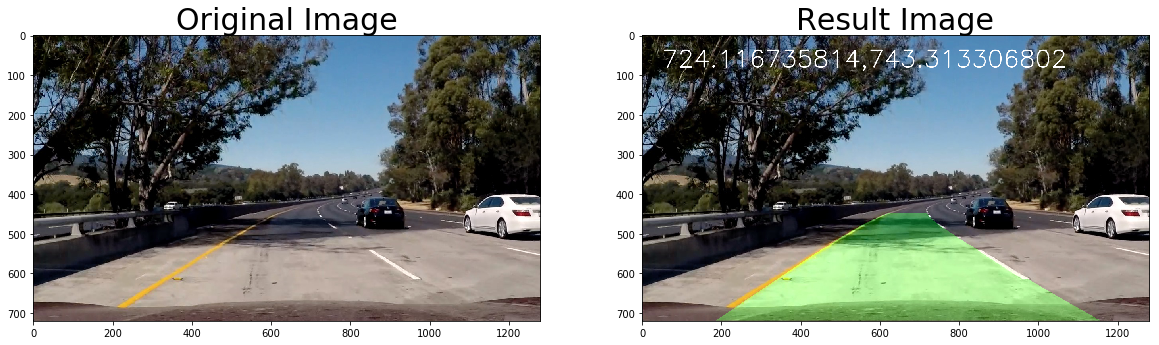

In [11]:
original_img = cv2.imread('./test_images/test5.jpg')
result_img = process_image(original_img)
%matplotlib inline


# Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(original_img[:,:,::-1])
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(result_img[:,:,::-1])
ax2.set_title('Result Image', fontsize=30)

print(right_fit)

In [12]:
white_output = 'output_video.mp4'
process_count = 0
clip1 = VideoFileClip("project_video.mp4")
def process_image_one(image):
    result = process_image(image)
    return result
white_clip = clip1.fl_image(process_image_one) 
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output_video.mp4
[MoviePy] Writing video output_video.mp4


100%|█████████▉| 1260/1261 [01:35<00:00, 13.23it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video.mp4 

CPU times: user 1min 40s, sys: 8.83 s, total: 1min 49s
Wall time: 1min 35s


Undistorting Test
===
* Apply a distortion correction to raw images.

In [13]:
def undistort_img(image):
    global mtx, dist
    undist_img = cv2.undistort(image, mtx, dist, None, mtx)
    return undist_img, mtx, dist

Text(0.5,1,'Undistorted Image')

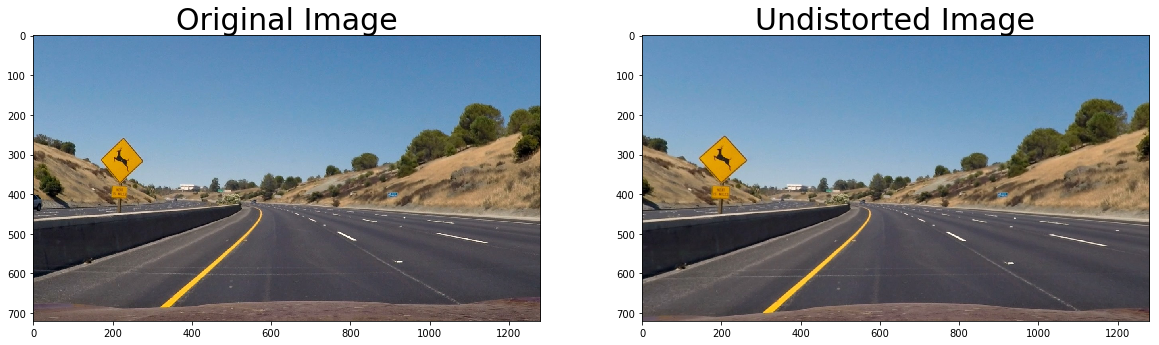

In [24]:
%matplotlib inline

# Test undistortion on an image

img = cv2.imread('./test_images/test2.jpg')
undist_img, mtx, dist = undistort_img(img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img[:,:,::-1])
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist_img[:,:,::-1])
ax2.set_title('Undistorted Image', fontsize=30)

* Use color transforms, gradients, etc., to create a thresholded binary image.

(720, 1280)


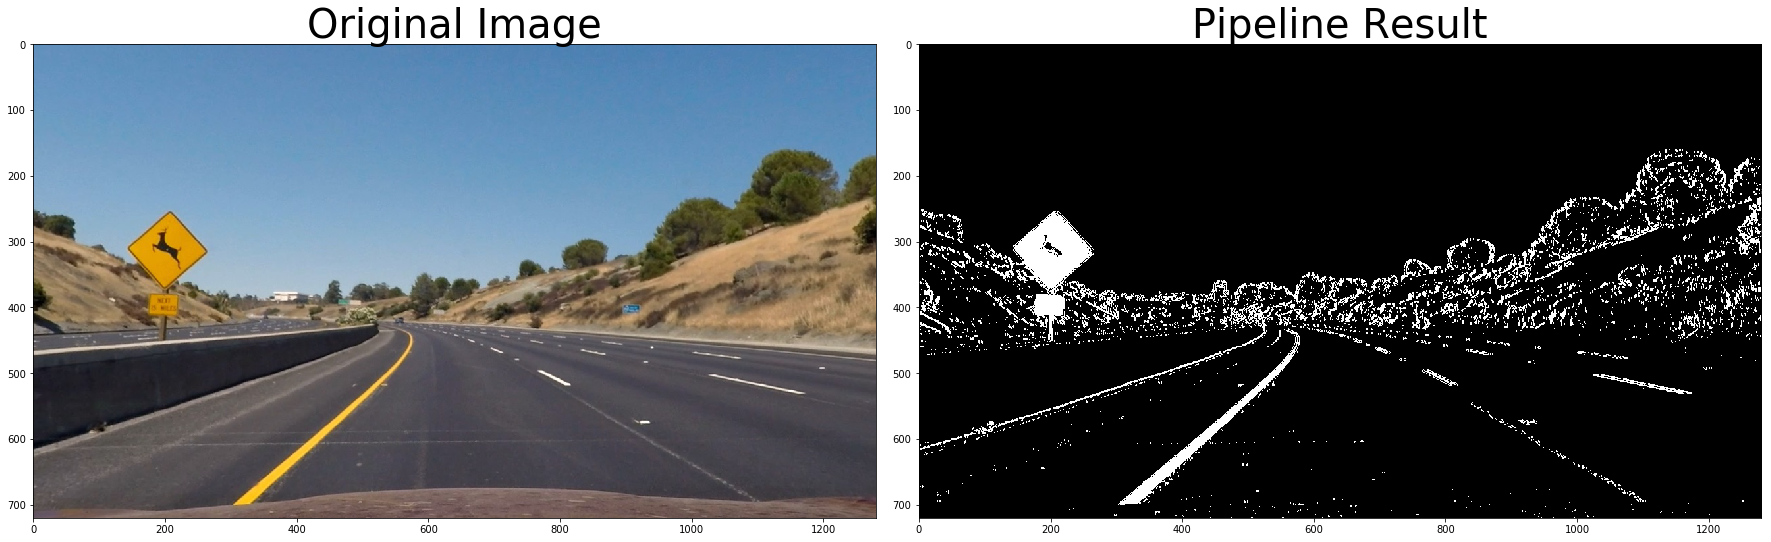

In [15]:
%matplotlib inline

result = get_binary_img(undist_img)

print(result.shape)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(undist_img[:,:,::-1])
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

* Apply a perspective transform to rectify binary image ("birds-eye view").

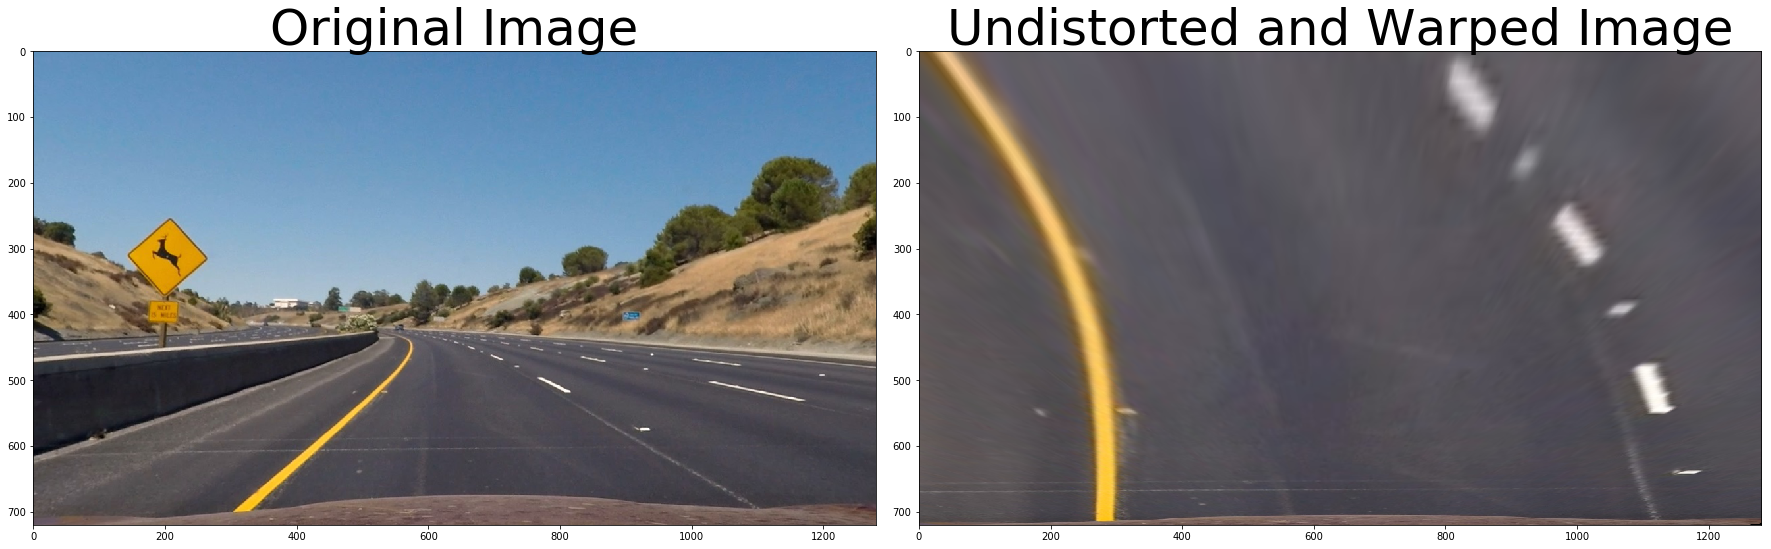

In [26]:
%matplotlib inline



# MODIFY THIS FUNCTION TO GENERATE OUTPUT 
# THAT LOOKS LIKE THE IMAGE ABOVE


top_down = cv2.warpPerspective(undist_img, perspective_M, (undist_img.shape[1], undist_img.shape[0]))
#top_down, perspective_M, invert_perspective_M = corners_unwarp(undist_img, col, row, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undist_img[:,:,::-1])
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down[:,:,::-1])
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


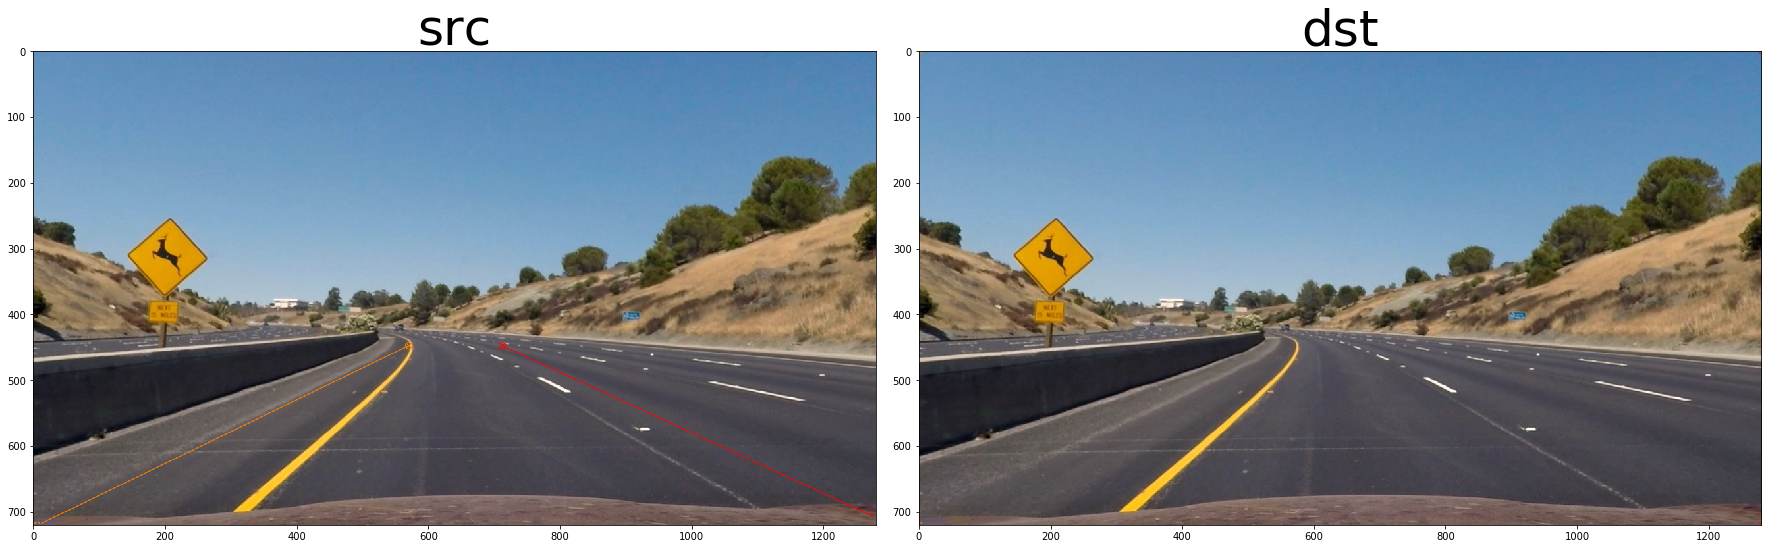

In [27]:
src_img = undist_img.copy();
dst_img = undist_img.copy();
cv2.drawChessboardCorners(src_img, (2, 2), src, True)
cv2.drawChessboardCorners(dst_img, (2, 2), dst, True)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(src_img[:,:,::-1])
ax1.set_title('src', fontsize=50)
ax2.imshow(dst_img[:,:,::-1])
ax2.set_title('dst', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [29]:
src

array([[  712.,   447.],
       [ 1305.,   720.],
       [    6.,   720.],
       [  570.,   447.]], dtype=float32)

In [30]:
dst

array([[ 1280.,     0.],
       [ 1280.,   720.],
       [    0.,   720.],
       [    0.,     0.]], dtype=float32)

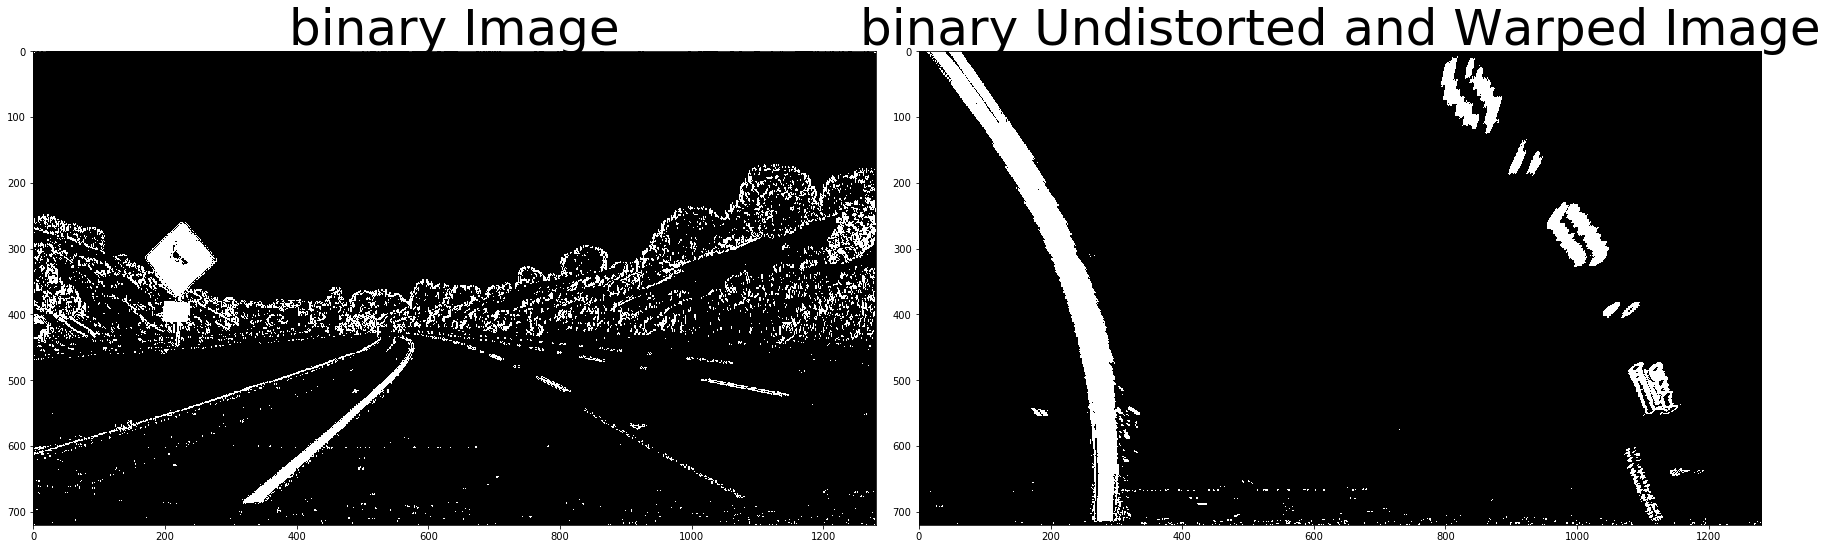

In [64]:
%matplotlib inline

binary_img = get_binary_img(img)
binary_warped = get_binary_img(top_down)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(binary_img, cmap='gray')
ax1.set_title('binary Image', fontsize=50)
ax2.imshow(binary_warped, cmap='gray')
ax2.set_title('binary Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

* Detect lane pixels and fit to find the lane boundary.

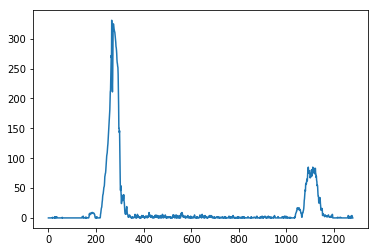

In [65]:
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)

(720, 0)

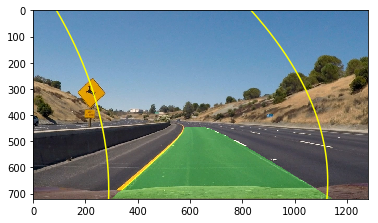

In [66]:
#result, out_img, left_fitx, right_fitx, ploty = fit_lane_line(img, binary_warped, invert_perspective_M)
result, out_img, left_fitx, right_fitx, ploty = fit_lane_line_continue(img, binary_warped, invert_perspective_M)

plt.imshow(result[:,:,::-1])
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)